In [47]:
import hydra
import torch
from lib.utils.config import load_config
from lib.optimizer.framework import NeuralOptimizer
from lib.data.loader import load_intrinsics
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera
from lib.utils.visualize import visualize_point2plane_error
import matplotlib.pyplot as plt


def path_to_abblation(path):
    return "_".join(path.split("/")[-3].split("_")[1:])


def eval_iterations(optimizer, datamodule, idx: int):
    optimizer.max_iters = 2
    optimizer.max_optims = 1
    out = None
    batch = None
    for i, b in enumerate(datamodule.val_dataloader()):
        if i == idx:
            with torch.no_grad():
                batch = optimizer.transfer_batch_to_device(b, "cuda", 0)
                out = optimizer(batch)
    return out, batch

def draw_and_save(img, path):
    # Display and save the error image
    plt.figure(figsize=(19.2, 10.8), dpi=100)  # Full HD size
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.savefig(path, bbox_inches='tight', pad_inches=0)  # Save without padding
    plt.show()

def load_flame_renderer():
    # instanciate similar to training
    cfg = load_config("train", ["data=synthetic"])
    K = load_intrinsics(data_dir=cfg.data.intrinsics_dir, return_tensor="pt")
    camera = Camera(
        K=K,
        width=cfg.data.width,
        height=cfg.data.height,
        near=cfg.data.near,
        far=cfg.data.far,
        scale=cfg.data.scale,
    )
    rasterizer = Rasterizer(width=camera.width, height=camera.height)
    renderer = Renderer(rasterizer=rasterizer, camera=camera)
    flame = hydra.utils.instantiate(cfg.model)
    return flame, renderer


def load_neural_optimizer(flame, renderer, path, override=[]):
    cfg = load_config("train", ["data=synthetic"] + override)
    correspondence = hydra.utils.instantiate(cfg.correspondence)
    weighting = hydra.utils.instantiate(cfg.weighting)
    residuals = hydra.utils.instantiate(cfg.residuals)
    regularize = hydra.utils.instantiate(cfg.regularize)
    neural_optimizer = NeuralOptimizer.load_from_checkpoint(
        path,
        renderer=renderer,
        flame=flame,
        correspondence=correspondence,
        regularize=regularize,
        residuals=residuals,
        weighting=weighting,
    )
    return neural_optimizer


def render_output(renderer, optimizer, out, batch):
    renderer.update(scale=1)
    pred_out = optimizer.flame.render(renderer, out["params"])
    gt_out = optimizer.flame.render(renderer, batch["params"])
    error_map = visualize_point2plane_error(
        s_point=gt_out["point"][0],
        t_normal=pred_out["normal"][0],
        t_point=pred_out["point"][0],
        t_mask=pred_out["mask"][0],
        max_error=2e-03,  # 2mm
    )
    renderer.update(scale=8)
    color = pred_out["color"][0].detach().cpu()
    return color, error_map


def load_icp_optimizer(flame, renderer, overrides):
    cfg = load_config(
        "train", ["data=synthetic", "optimizer.output_dir=none"] + overrides
    )
    correspondence = hydra.utils.instantiate(cfg.correspondence)
    weighting = hydra.utils.instantiate(cfg.weighting)
    residuals = hydra.utils.instantiate(cfg.residuals)
    optimizer = hydra.utils.instantiate(cfg.optimizer)
    regularize = hydra.utils.instantiate(cfg.regularize)
    icp_optimizer = hydra.utils.instantiate(
        cfg.framework,
        flame=flame,
        logger=None,
        renderer=renderer,
        correspondence=correspondence,
        regularize=regularize,
        residuals=residuals,
        optimizer=optimizer,
        weighting=weighting,
    )
    return icp_optimizer.to("cuda")


# setup the datamodule
def load_datamodule(renderer, start_frame, end_frame, jump_size=1):
    cfg = load_config("train", ["data=synthetic"])
    datamodule = hydra.utils.instantiate(
        cfg.data,
        renderer=renderer,
        val_dataset=dict(
            start_frame=start_frame,
            end_frame=end_frame,
            jump_size=jump_size
        ),
    )
    datamodule.setup("fit")
    return datamodule

Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01


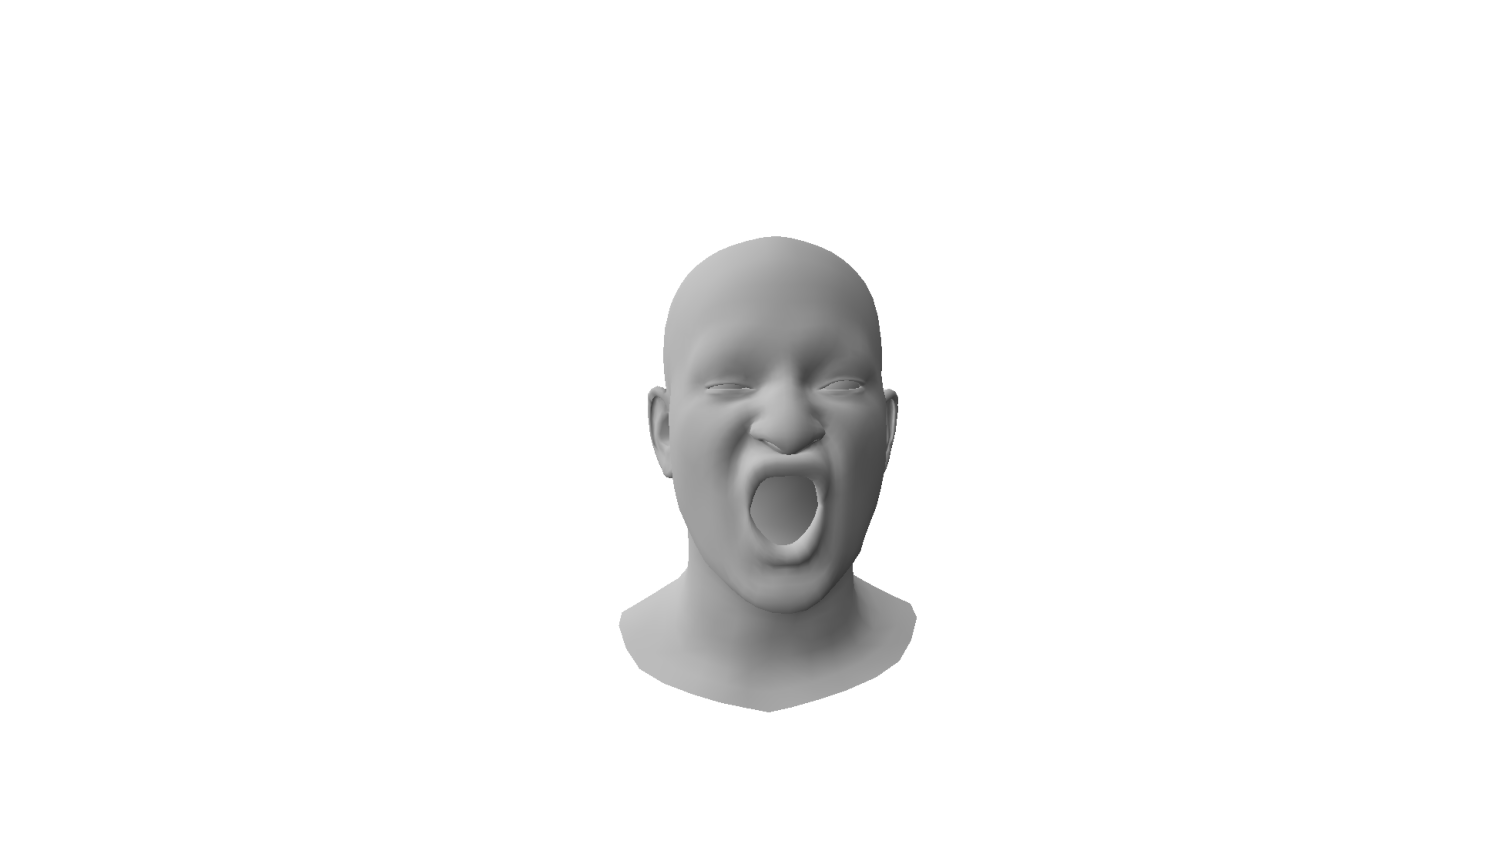

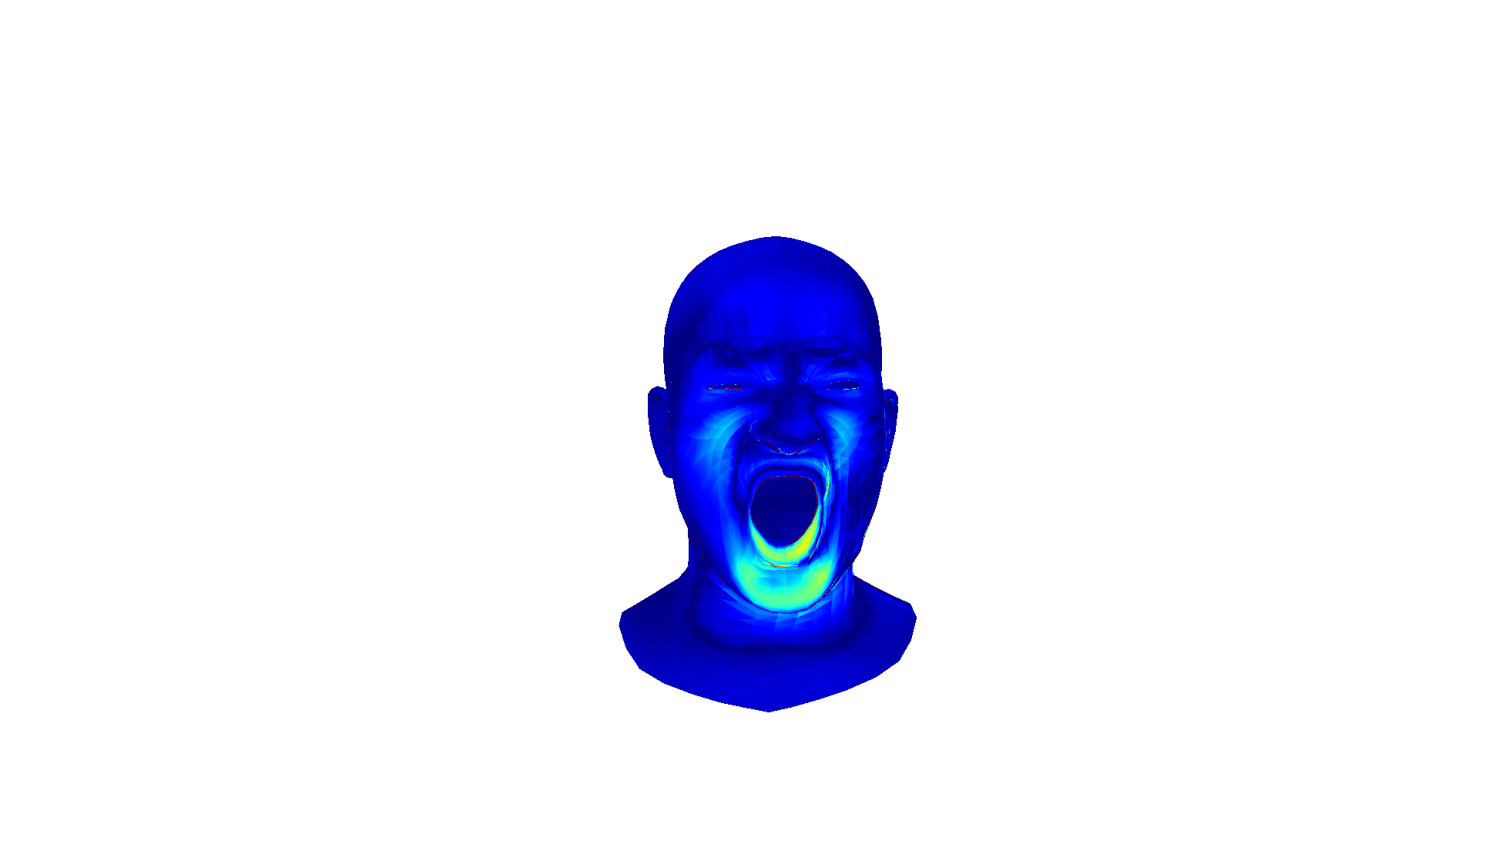

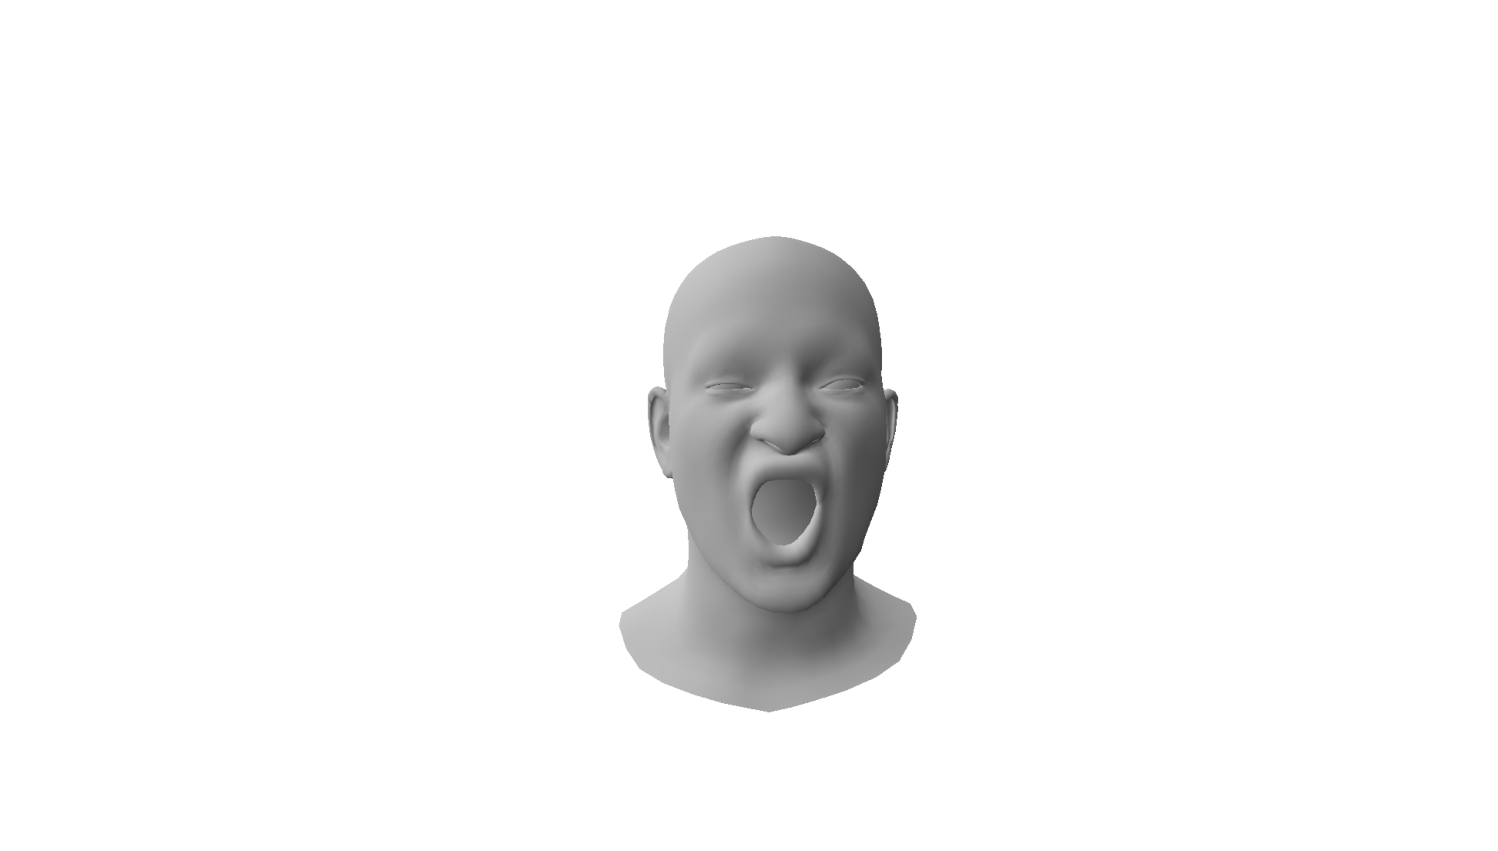

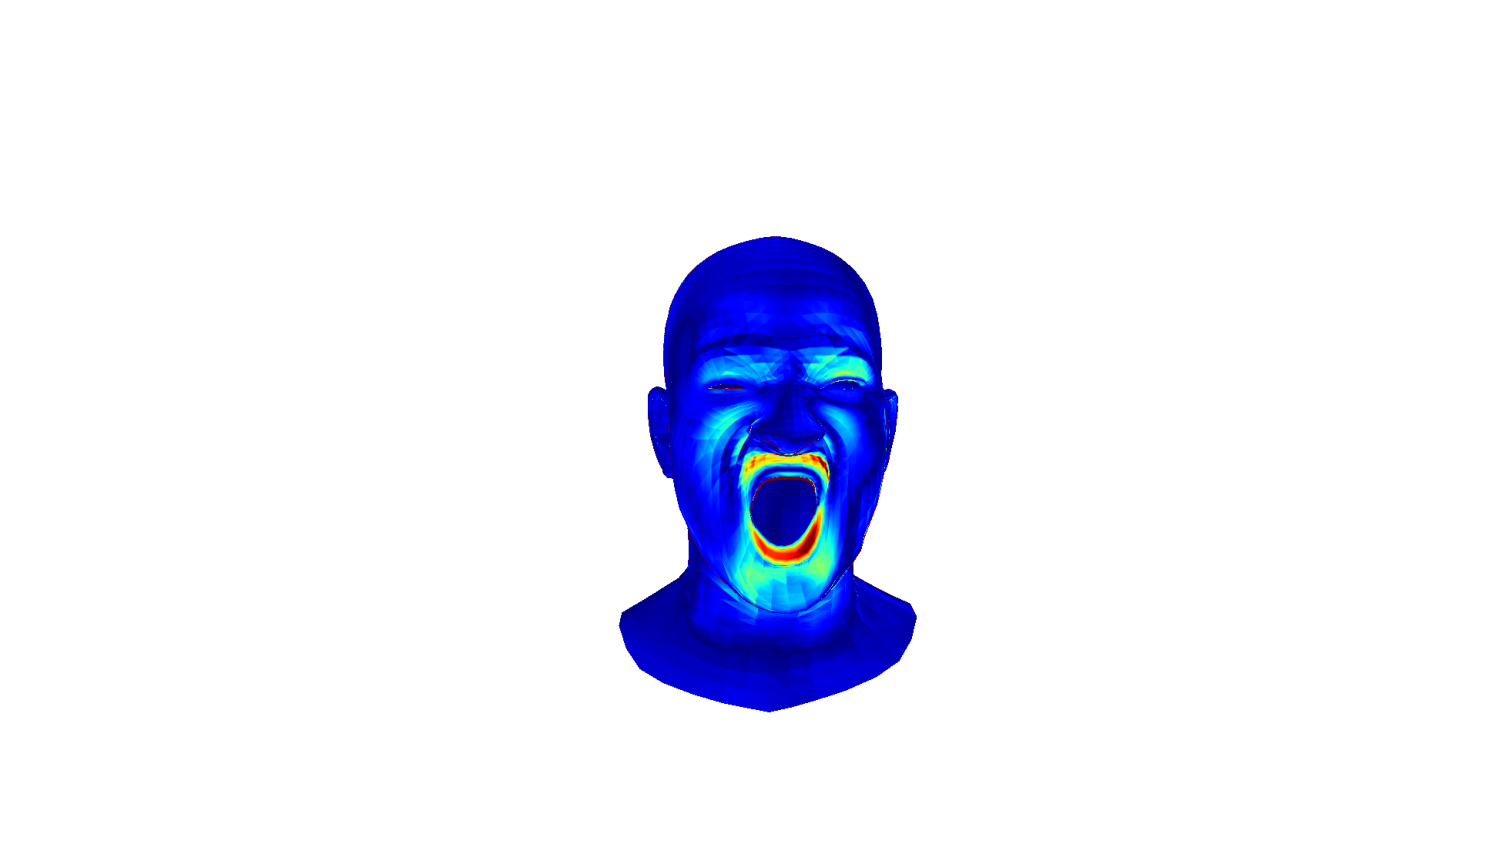

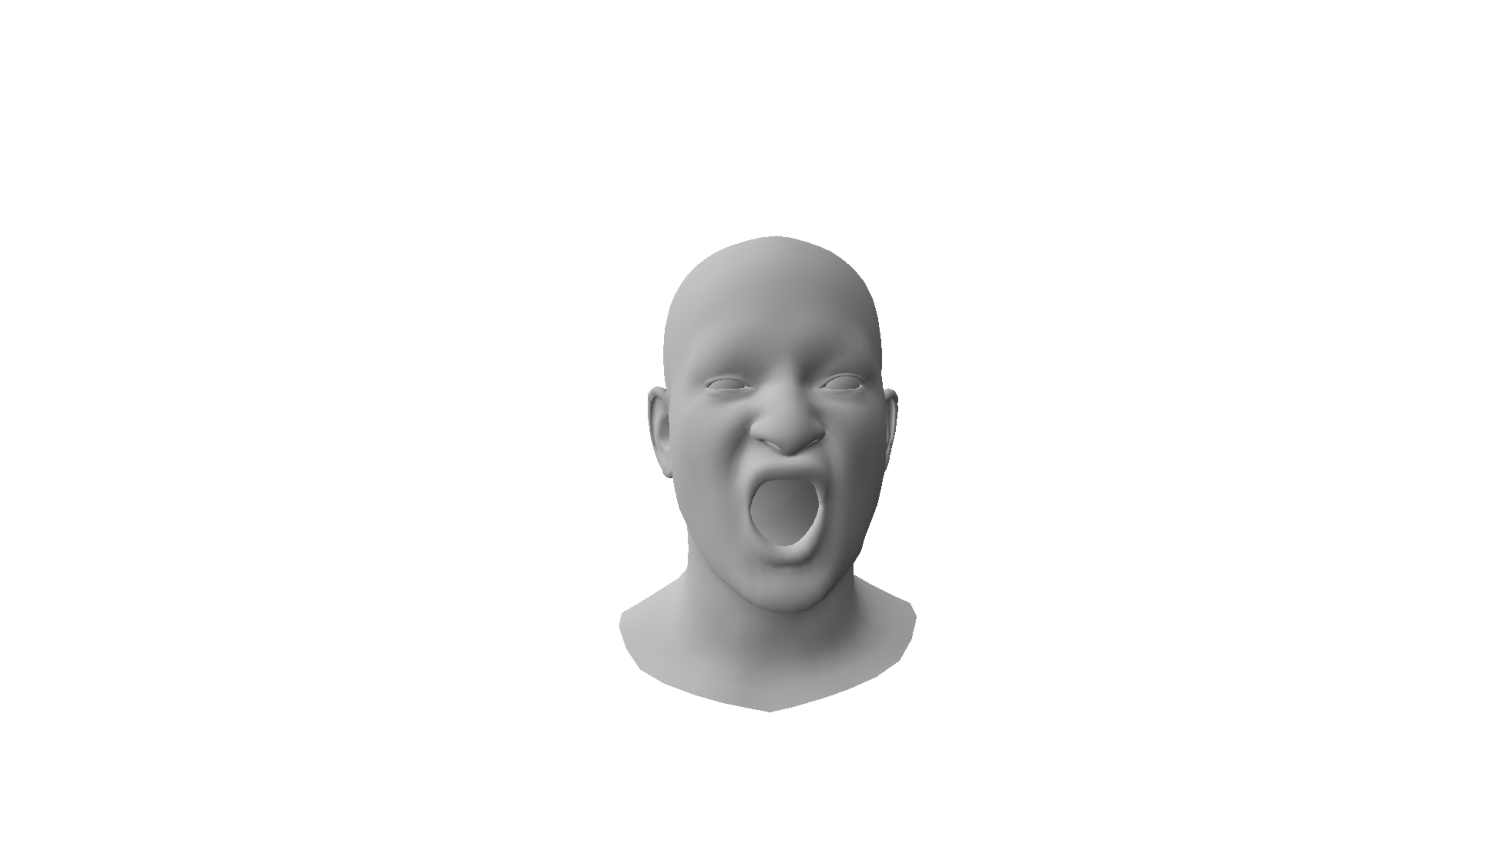

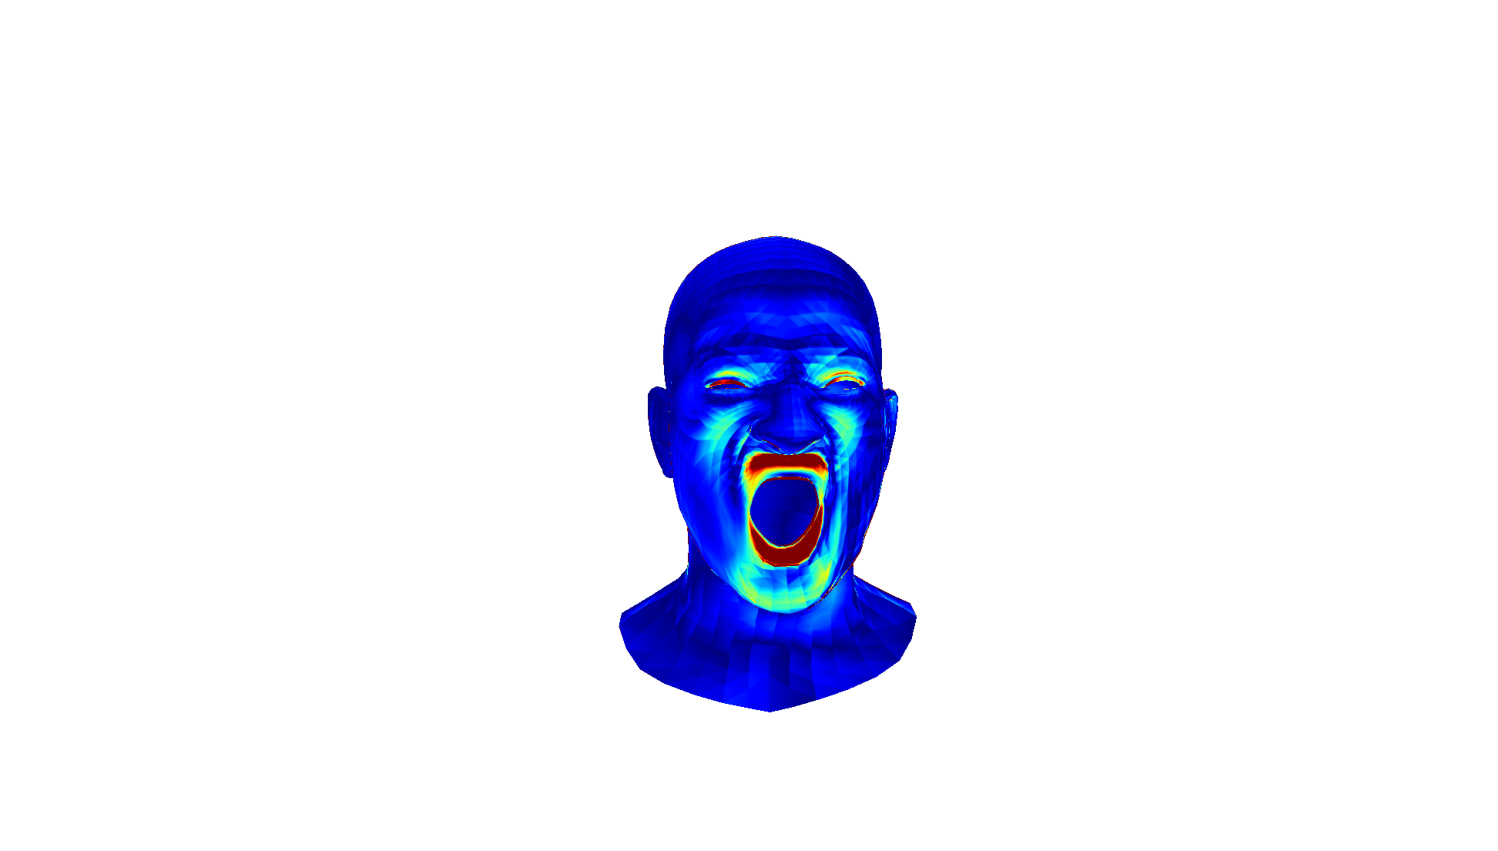

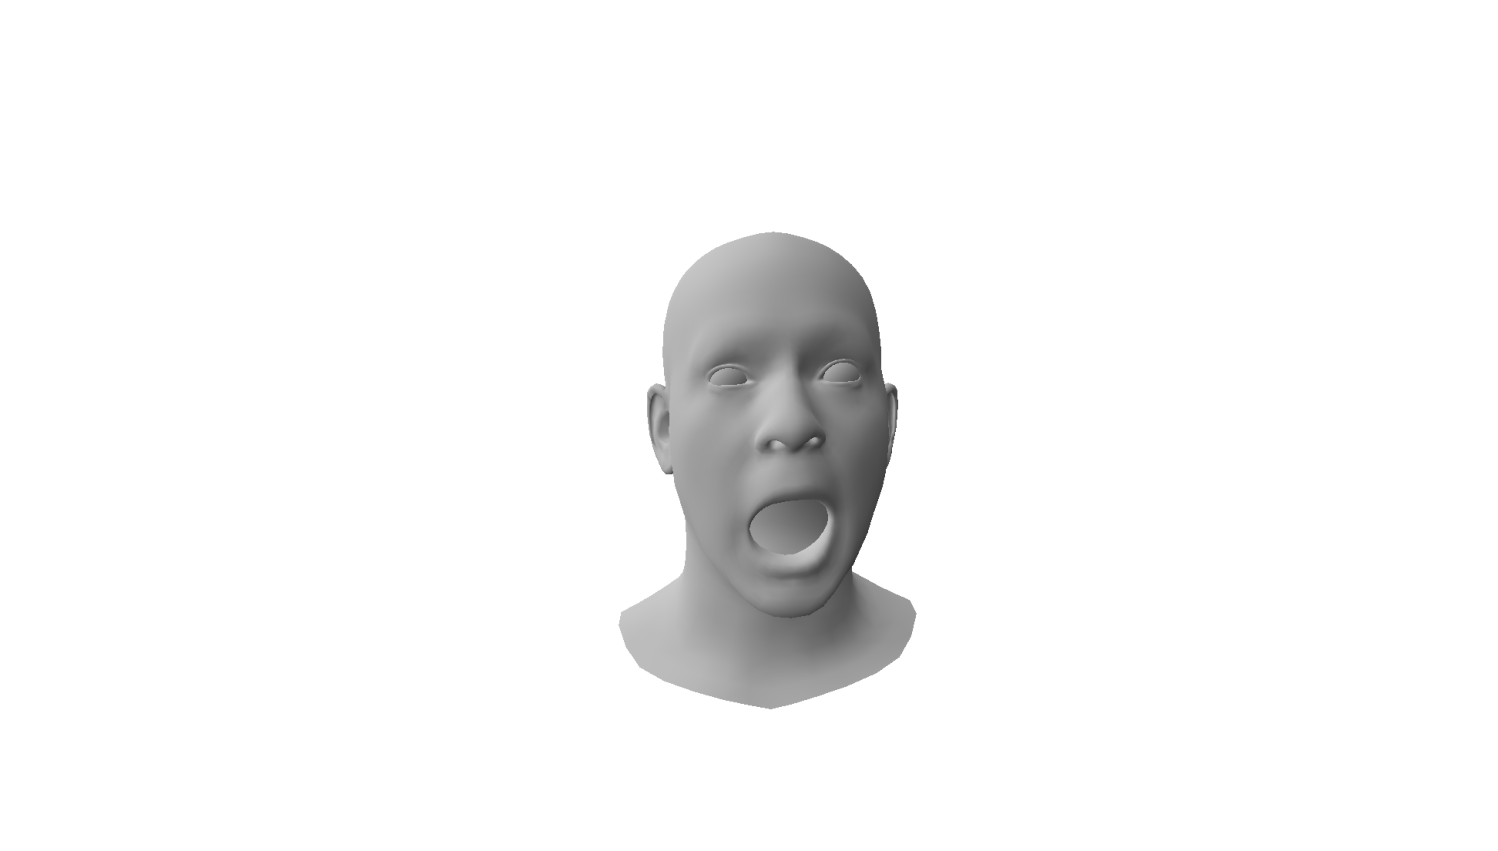

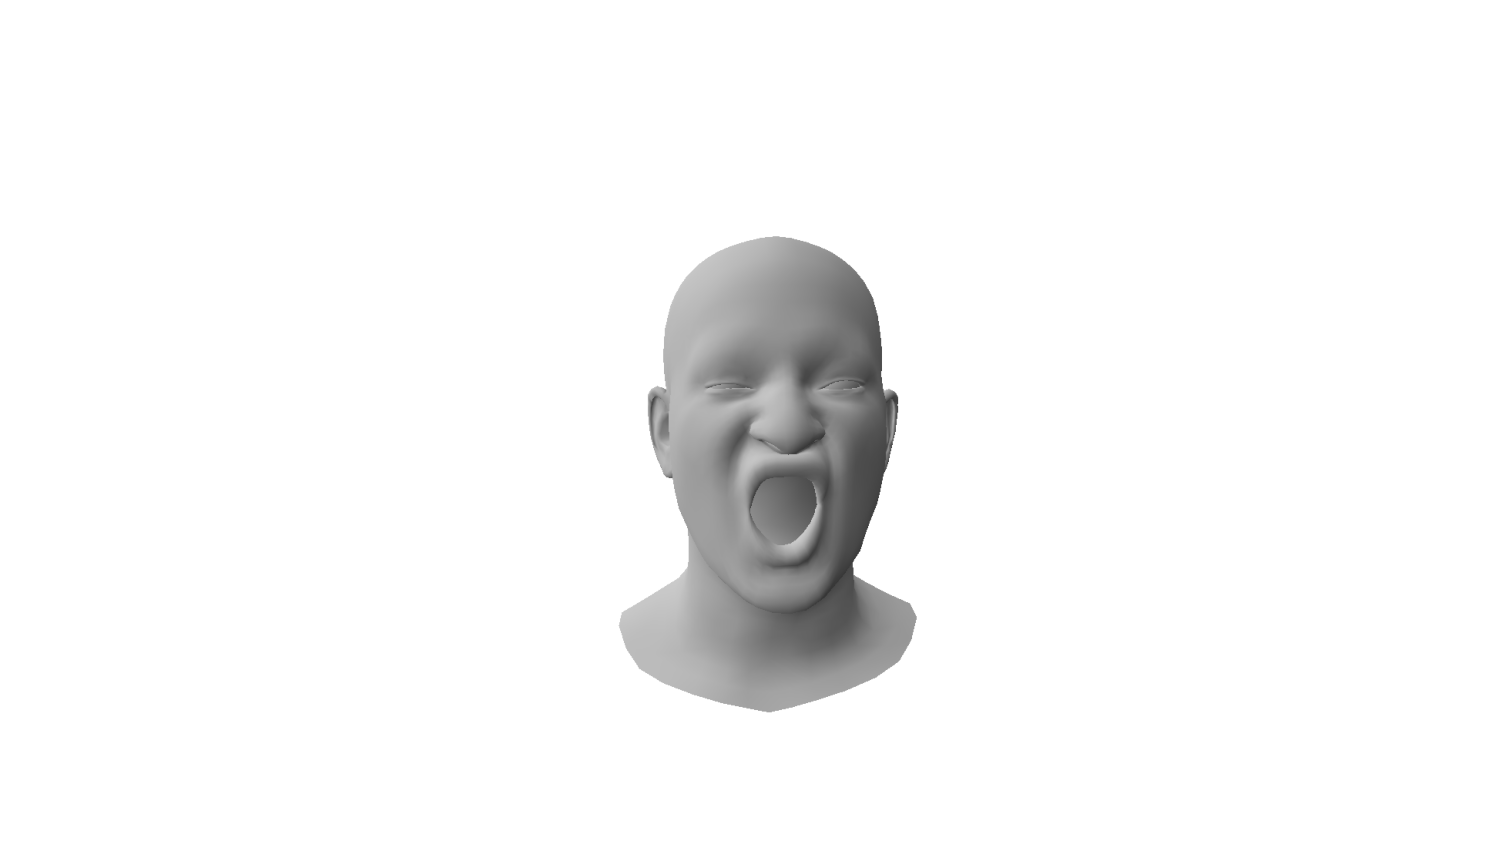

In [49]:
# settings
N = 2
step_size = 0.7

# idxs = [1]
# start_frame = 10
# end_frame = 11

idxs = [5]
start_frame = 10
end_frame = 11


# checkpoints
wo_neural_weights = "/home/borth/GuidedResearch/checkpoints/synthetic_lr/wo_neural_weights.ckpt"
ours = "/home/borth/GuidedResearch/checkpoints/synthetic_lr/ours2.ckpt"

# loadings
flame, renderer = load_flame_renderer()
datamodule = load_datamodule(renderer, start_frame, end_frame, 1)

for idx in idxs:
    idx = idx
    path = ours
    optimizer = load_neural_optimizer(flame, renderer, path)
    optimizer.optimizer.step_size = step_size
    out, batch = eval_iterations(optimizer, datamodule, idx)
    color, error = render_output(renderer, optimizer, out, batch)
    draw_and_save(color, f"results/ablation/ours_color_{idx}.png")
    draw_and_save(error, f"results/ablation/ours_error_{idx}.png")

    path = wo_neural_weights
    overrides = ["weighting.dummy_weight=True"]
    optimizer = load_neural_optimizer(flame, renderer, path, overrides)
    optimizer.optimizer.step_size = step_size
    out, batch = eval_iterations(optimizer, datamodule, idx)
    color, error = render_output(renderer, optimizer, out, batch)
    draw_and_save(color, f"results/ablation/wo_weight_color_{idx}.png")
    draw_and_save(error, f"results/ablation/wo_weight_error_{idx}.png")

    overrides = ["weighting=dummy", "regularize=dummy"]
    optimizer = load_icp_optimizer(flame, renderer, overrides)
    optimizer.optimizer.step_size = step_size
    out, batch = eval_iterations(optimizer, datamodule, idx)
    color, error = render_output(renderer, optimizer, out, batch)
    draw_and_save(color, f"results/ablation/icp_color_{idx}.png")
    draw_and_save(error, f"results/ablation/icp_error_{idx}.png")

    out, batch = eval_iterations(optimizer, datamodule, idx)
    out["params"] = batch["init_params"]
    color, error = render_output(renderer, optimizer, out, batch)
    draw_and_save(color, f"results/ablation/init_color_{idx}.png")
    out["params"] = batch["params"]
    color, error = render_output(renderer, optimizer, out, batch)
    draw_and_save(color, f"results/ablation/gt_color_{idx}.png")

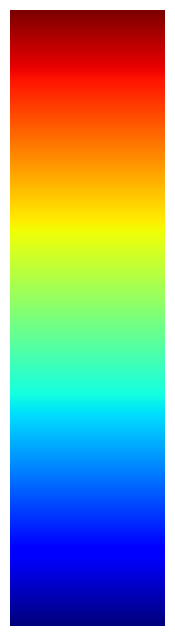

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Create a vertical gradient image using the reversed "jet" colormap
cmap_name='jet'
num_colors=256
cmap = plt.get_cmap(cmap_name)
gradient = np.linspace(0, 1, num_colors).reshape(-1, 1)  # Create a vertical gradient
gradient = np.flipud(gradient)  # Flip the gradient to have red at the top

plt.figure(figsize=(2, 8))  # Set the figure size
plt.imshow(gradient, aspect='auto', cmap=cmap)  # Display the gradient
plt.axis('off')  # Turn off the axis
plt.savefig("results/ablation/error_bar_2mm.png", bbox_inches='tight', pad_inches=0)  # Save without padding
plt.show()